# Multi-modal data with a GraphQL alternative

This notebook will demonstrate working with multi-modal or multi-source data. By default, Hyrax assumes only a single dataset will be used for a given model.

As before, the two required configuration parameters are `config['general']['data_dir']` (to define the location of the data) and `config['data_set']['name']` (to define the dataset class that will load specific data from disk).

Below we the standard approach of loading the default dataset defined in the Hyrax config using `h.prepare()`. We then print the dataset object to see the basic information about it.

In [1]:
from hyrax import Hyrax

h = Hyrax()

# Set a few configs for later use
h.config["train"]["epochs"] = 1
h.config["data_set"]["HyraxRandomDataset"]["shape"] = (1, 32, 32)
h.config["data_set"]["HyraxRandomDataset"]["size"] = 50000

[2025-09-19 12:21:00,587 hyrax:INFO] Runtime Config read from: /Users/drew/code/hyrax/src/hyrax/hyrax_default_config.toml


## Attaching a iterable datasets to a model
The following shows how to set the dataset to be the `HyraxRandomIterableDataset`.

When experimentation is complete, the following can also be specified directly in a configuration .toml file like so:
```toml
[model_inputs]

[model_inputs.rando]
dataset_class = "HyraxRandomIterableDataset"
data_location = "./data"
fields = ["object_id", "image"]



In [2]:
h.config["model_inputs"] = {
    "rando_0": {
        "dataset_class": "HyraxRandomIterableDataset",
        "data_location": "./data",
        "fields": ["object_id", "image"],
        "primary_id_field": "object_id",
    },
}

## Examine the new iterable dataset
As before, calling ``h.prepare()`` will return an instance of the ``DataProvider`` dataset.
The ``DataProvider`` class can be thought of as a container of multiple datasets, as well as a gateway (in GraphQL terminology)
that will send requests for specific data to the datasets it contains. Printing the dataset object will show the configuration of the dataset.

In [3]:
ds = h.prepare()
print(ds)

[2025-09-19 12:21:03,389 hyrax.prepare:INFO] Finished Prepare


In [4]:
fields = ds.metadata_fields()
ds.metadata(idxs=[0, 1, 2], fields=fields)

array([('53', 25000. , 16666.66666667), ('54', 24999.5, 16666.33333333),
       ('55', 24999. , 16666.        )],
      dtype=[('object_id', '<U5'), ('meta_field_1', '<f8'), ('meta_field_2', '<f8')])

In [5]:
print(f"Is iterable: {ds.is_iterable()}")  # Should return True
print(f"Is mappable: {ds.is_map()}")  # Should return False

Is iterable: True
Is mappable: False


In [6]:
ds.metadata_fields()

['object_id', 'meta_field_1', 'meta_field_2']

In [7]:
samp = next(iter(ds))
print("Fields from samp")
print(samp)
print(f"shape: {samp['data']['image'].shape}")
print(f"label: {samp['data']['label']}")

Fields from samp
{'data': {'index': 0, 'object_id': '53', 'image': array([[[0.08925092, 0.773956  , 0.6545715 , ..., 0.44341415,
         0.45045954, 0.22723871],
        [0.09213591, 0.55458474, 0.8878898 , ..., 0.7447621 ,
         0.36664265, 0.9675097 ],
        [0.41085035, 0.32582533, 0.90553576, ..., 0.38747835,
         0.8980876 , 0.28832805],
        ...,
        [0.41836828, 0.5780172 , 0.5375471 , ..., 0.6346291 ,
         0.9714626 , 0.41181087],
        [0.15344363, 0.40878308, 0.8401149 , ..., 0.7874322 ,
         0.3427019 , 0.5491443 ],
        [0.19697303, 0.43141818, 0.5296637 , ..., 0.07205909,
         0.8685205 , 0.84199315]]], dtype=float32), 'label': np.int64(1)}, 'object_id': '53'}
shape: (1, 32, 32)
label: 1


## Pass the data through ``to_tensor``
Since we have access to the model class, we can call the ``to_tensor`` method with example data.
This allows easy checking that the output matches the expectations of the model architecture.

In this example, we expect ``to_tensor`` to return a tuple of (Tensor, int), or specifically a multi-channel image and a label.

In [8]:
@staticmethod
def to_tensor(data_dict):
    """This function converts structured data to the input tensor we need to run

    Parameters
    ----------
    data_dict : dict
        The dictionary returned from our data source
    """
    rando_0 = data_dict.get("data", {})

    if "image" in rando_0:
        image_0 = rando_0["image"]

    return image_0


m = h.model()
m.to_tensor = to_tensor

In [9]:
res = m.to_tensor(samp)
print(f"Type and shape of resulting image: {type(res)}, {res.shape}")

Type and shape of resulting image: <class 'numpy.ndarray'>, (1, 32, 32)


## Train with this model
Now that we've seen that the ``to_tensor`` method is returning a reasonable form of data, we can train our model.
As before, we call ``h.train()``.
While it is quiet verbose, the initialization logging shows that the model instance is created with data from
the ``DataProvider`` class, and that our new implementation of ``to_tensor`` is being used to manipulate
the data from ``DataProvider`` into the a form that our model architecture accepts.

In [10]:
h.train()

[2025-09-19 12:21:03,658 hyrax.models.hyrax_autoencoder:INFO] Found shape: (1, 32, 32) in data sample, using this to initialize model.
[2025-09-19 12:21:03,662 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
2025-09-19 12:21:03,722 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<hyrax.data_sets.ran': 
	{'pin_memory': True, 'batch_size': 512, 'shuffle': False}
2025-09-19 12:21:03,723 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<hyrax.data_sets.ran': 
	{'pin_memory': True, 'batch_size': 512, 'shuffle': False}
/Users/drew/opt/miniconda3/envs/hyrax/lib/python3.12/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2025/09/19 12:21:03 INFO mlflow.system_metrics.system_metrics_monitor: Skip

1it [00:00, ?it/s]

[2025-09-19 12:21:10,042 hyrax.pytorch_ignite:INFO] Total training time: 6.21[s]
[2025-09-19 12:21:10,042 hyrax.pytorch_ignite:INFO] Latest checkpoint saved as: /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122103-train-LRTA/checkpoint_epoch_1.pt
[2025-09-19 12:21:10,042 hyrax.pytorch_ignite:INFO] Best metric checkpoint saved as: /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122103-train-LRTA/checkpoint_1_loss=-85.7166.pt
2025/09/19 12:21:10 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/19 12:21:10 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-09-19 12:21:10,057 hyrax.verbs.train:INFO] Finished Training
[2025-09-19 12:21:10,540 hyrax.model_exporters:INFO] Exported model to ONNX format: /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122103-train-LRTA/example_model_opset_20.onnx


HyraxAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=64, bias=True)
  )
  (dec_linear): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): 

In [11]:
h.infer()

[2025-09-19 12:21:10,708 hyrax.models.hyrax_autoencoder:INFO] Found shape: (1, 32, 32) in data sample, using this to initialize model.
[2025-09-19 12:21:10,711 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
2025-09-19 12:21:10,764 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<hyrax.data_sets.ran': 
	{'sampler': None, 'batch_size': 512, 'shuffle': False, 'pin_memory': False}
[2025-09-19 12:21:10,775 hyrax.verbs.infer:INFO] Saving inference results at: /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122110-infer-0uXO
[2025-09-19 12:21:11,035 hyrax.pytorch_ignite:INFO] Evaluating model on device: mps
[2025-09-19 12:21:11,036 hyrax.pytorch_ignite:INFO] Total epochs: 1


1it [00:00, ?it/s]

[2025-09-19 12:21:12,649 hyrax.pytorch_ignite:INFO] Total evaluation time: 1.61[s]
[2025-09-19 12:21:12,702 hyrax.verbs.infer:INFO] Inference Complete.


# Things get not-so-great after this
From here we really need to consider how we save state.
We need to make sure that the datasets collected in ``DataProvider`` are copied to the config.
We need to figure out how to recreate the current DataProvider from the config.
And we need to figure out when to use the contents of the persisted config file vs.
when to use the ``data`` attribute in the model class.

In [12]:
h.umap()

[2025-09-19 12:21:15,553 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122110-infer-0uXO for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-09-19 12:21:15,744 hyrax.verbs.umap:INFO] Saving UMAP results to /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122115-umap--ysO
[2025-09-19 12:21:15,918 hyrax.verbs.umap:INFO] Fitting the UMAP
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[2025-09-19 12:21:20,700 hyrax.verbs.umap:INFO] Saving fitted UMAP Reducer


Creating lower dimensional representation using UMAP::   0%|          | 0/98 [00:00<?, ?it/s]

[2025-09-19 12:22:02,897 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP


[2025-09-19 12:22:05,418 hyrax.verbs.visualize:INFO] UMAP directory not specified at runtime. Reading from config values.
[2025-09-19 12:22:05,419 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122115-umap--ysO for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-09-19 12:22:05,788 hyrax.verbs.visualize:INFO] Rendering UMAP from the following directory: /Users/drew/code/hyrax/docs/pre_executed/results/20250919-122115-umap--ysO


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
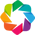

BokehModel(combine_events=True, render_bundle={'docs_json': {'262884bd-36e8-4238-a6b2-811d8accf185': {'version…

In [13]:
h.config["visualize"]["fields"] = ["meta_field_1", "meta_field_2"]
v = h.visualize()